In [1]:
import os
import shap
import getpass
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from datetime import timedelta, datetime
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras import backend as K, losses, optimizers, layers, models, utils, callbacks


# Make sure to update the paths in this notebook
This cell below and one of the last cells in Save Preformance needs your local path to your data

## Load Data 🩻

In [2]:
# Update this path
data_dir = "/Users/owenclary/code/Owencclary/x_ray_lewagon2024/data/Bone Break Classification"

# Load the train data
train_data = utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="int",
    validation_split=0.1,
    subset="training",
    shuffle=True,
    color_mode="rgb",
    image_size=(256,256),
    batch_size=64,
    seed=40
)
[]
# Load the test data
validation_data = utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="int",
    validation_split=0.1,
    subset="validation",
    color_mode="rgb",
    image_size=(256,256),
    batch_size=64,
    seed=42
)

Found 9391 files belonging to 11 classes.
Using 8452 files for training.
Found 9391 files belonging to 11 classes.
Using 939 files for validation.


## Prepresses Data 🔧

In [3]:
# Inspect class names
class_names = train_data.class_names
print("Class names: ", class_names)
print("Num Classes: ", len(class_names))

Class names:  ['Avulsion fracture', 'Comminuted fracture', 'Fracture Dislocation', 'Greenstick fracture', 'Hairline Fracture', 'Impacted fracture', 'Longitudinal fracture', 'Oblique fracture', 'Pathological fracture', 'Spiral Fracture', 'non_fractured']
Num Classes:  11


In [4]:
# Data preprocessing
def preprocess(img):
    img = tf.cast(img, "float32") / 255.0
    return img

train_dataset = train_data.map(lambda x, y: (preprocess(x), y))
val_dataset = validation_data.map(lambda x, y: (preprocess(x), y))

In [5]:
# Get train data and labels
x_train = []
y_train = []

for images, labels in train_dataset:
    # Append train data to x_train
    x_train.append(images.numpy())

    # Append labels to y_train
    y_train.append(labels.numpy())

# Concatenate all the batches to get the full list
x_train = np.concatenate(x_train, axis=0)
y_train = np.concatenate(y_train, axis=0)

2024-06-06 12:45:05.075848: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [6]:
# Get val data and labels
x_val = []
y_val = []

for images, labels in val_dataset:
    # Append train data to x_train
    x_val.append(images.numpy())

    # Append labels to y_train
    y_val.append(labels.numpy())

# Concatenate all the batches to get the full list
x_val = np.concatenate(x_val, axis=0)
y_val = np.concatenate(y_val, axis=0)

In [7]:
# One-hot encode the train, val data
NUM_CLASSES = len(class_names)

y_train = utils.to_categorical(y_train, NUM_CLASSES)
y_val = utils.to_categorical(y_val, NUM_CLASSES)

In [8]:
# Further data augmentation for EfficientNet
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow(x_train, y_train, batch_size=32)
val_generator = datagen.flow(x_val, y_val, batch_size=32)

## Initialize Model 🤌



Add Code to test a model


In [9]:
def initialize_model(x_train):

    # CODE HERE
    pass


model = initialize_model(x_train)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 8, 8, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 100)               128100    
                                                                 
 batch_normalization_1 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                        

## Train the Model 💪 

In [16]:
# Save checkpoints to monitor best performing models
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/best_model_weights.h5",
    save_weights_only=True,  # Save only the weights
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    verbose=1
)

tensorboard_callback = callbacks.TensorBoard(
    log_dir='./logs',
    histogram_freq=1,
    write_graph=True,
    write_images=True,
    update_freq='epoch'
)

In [18]:
# Start timer
start_train_time = datetime.now()

epochs = 10

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')

# Fit the model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[early_stopping, model_checkpoint_callback, tensorboard_callback]
)


# End timer
end_train_time = datetime.now()
train_time = (end_train_time - start_train_time).total_seconds()

Epoch 1/10
265/265 [==============================] - ETA: 0s - loss: 2.3898 - accuracy: 0.1200
Epoch 1: val_loss improved from inf to 2.35478, saving model to ./checkpoint/best_model_weights.h5
265/265 [==============================] - 238s 893ms/step - loss: 2.3898 - accuracy: 0.1200 - val_loss: 2.3548 - val_accuracy: 0.1235
Epoch 2/10
265/265 [==============================] - ETA: 0s - loss: 2.3856 - accuracy: 0.1145
Epoch 2: val_loss improved from 2.35478 to 2.35369, saving model to ./checkpoint/best_model_weights.h5
265/265 [==============================] - 234s 882ms/step - loss: 2.3856 - accuracy: 0.1145 - val_loss: 2.3537 - val_accuracy: 0.1235
Epoch 3/10
265/265 [==============================] - ETA: 0s - loss: 2.3842 - accuracy: 0.1225
Epoch 3: val_loss improved from 2.35369 to 2.35195, saving model to ./checkpoint/best_model_weights.h5
265/265 [==============================] - 227s 856ms/step - loss: 2.3842 - accuracy: 0.1225 - val_loss: 2.3520 - val_accuracy: 0.1246
Ep

## Evaluate the Model 🕵️‍♂️

In [19]:
# Get Loss and Accuracy metrics
train_loss = history.history["loss"]
train_accuracy = history.history["accuracy"]
val_loss = history.history["val_loss"]
val_accuracy = history.history["accuracy"]

print('Train Loss: ', train_loss)
print('Train Accuracy: ', train_accuracy)
print('Val Loss: ', val_loss)
print('Val Accuracy: ', val_accuracy)

Train Loss:  [2.3897745609283447, 2.385568141937256, 2.384232759475708, 2.3782219886779785, 2.3765087127685547, 2.3727762699127197, 2.372363567352295, 2.3709676265716553, 2.3679161071777344, 2.3686769008636475]
Train Accuracy:  [0.11997160315513611, 0.11452910304069519, 0.12245622277259827, 0.11938002705574036, 0.12517747282981873, 0.12210127711296082, 0.12340274453163147, 0.1302650272846222, 0.12399432063102722, 0.12352105975151062]
Val Loss:  [2.3547840118408203, 2.353689193725586, 2.3519513607025146, 2.354198455810547, 2.351229667663574, 2.351464033126831, 2.3524930477142334, 2.3506405353546143, 2.3506507873535156, 2.351106882095337]
Val Accuracy:  [0.11997160315513611, 0.11452910304069519, 0.12245622277259827, 0.11938002705574036, 0.12517747282981873, 0.12210127711296082, 0.12340274453163147, 0.1302650272846222, 0.12399432063102722, 0.12352105975151062]


In [20]:
# Start timer
start_eval_time = datetime.now()

# Evaluate model
model.evaluate(x_val, y_val)

# End timer
end_eval_time = datetime.now()
eval_time = (end_eval_time - start_eval_time).total_seconds()

30/30 [==============================] - 13s 426ms/step - loss: 2.3502 - accuracy: 0.1235


## Plote Learning Curve 📊

ValueError: x and y must have same first dimension, but have shapes (1,) and (10,)

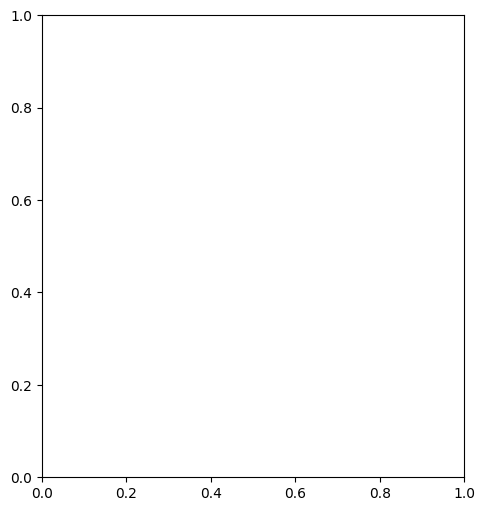

In [21]:
# Plot learning curve
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'r-', label="Training Loss")
plt.plot(epochs, val_loss, 'b-', label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'r-', label="Training Accuracy")
plt.plot(epochs, val_accuracy, 'b-', label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

## Calculate Preformance 🔍

In [22]:
# Start prediction timer
start_pred_time = datetime.now()

# Get predictions of the model
preds = model.predict(x_val)
CLASSES = np.array(class_names)
predictions = CLASSES[np.argmax(preds, axis=-1)]
y_val_classes = CLASSES[np.argmax(y_val, axis=-1)]

# Ender prediction timer
end_pred_time = datetime.now()
pred_time = (end_pred_time - start_pred_time).total_seconds()

30/30 [==============================] - 16s 494ms/step


In [23]:
# Calculate accuracy, precision, recall, f1
accuracy = accuracy_score(predictions, y_val_classes)
precision = precision_score(predictions, y_val_classes, average='weighted')
recall = recall_score(predictions, y_val_classes, average='weighted')
f1 = f1_score(predictions, y_val_classes, average='weighted')

# Save the metrics to a file
with open("metrics.txt", "w") as file:
    file.write(f"{accuracy}\n")
    file.write(f"{precision}\n")
    file.write(f"{recall}\n")
    file.write(f"{f1}\n")

# Optionally, print the metrics for quick reference
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.1235356762513312
Precision: 1.0
Recall: 0.1235356762513312
F1 Score: 0.21990521327014217


/Users/owenclary/.pyenv/versions/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Save Preformance to CSV 📝

In [24]:
def log_model_metrics(metrics_file, csv_file, model_name, train_time, eval_time, pred_one_time):

    # Load metrics generated by train_eval.py
    metrics_df = pd.read_csv(metrics_file, header=None, names=["value"])
    accuracy = float(metrics_df.iloc[0].value)
    precision = float(metrics_df.iloc[1].value)
    recall = float(metrics_df.iloc[2].value)
    f1 = float(metrics_df.iloc[3].value)

    # Log results to DataFrame
    columns = ["name", "model", "train_time", "test_time", "pred_one_time", "accuracy", "precision", "recall", "f1"]
    name = getpass.getuser()  # Get the username of the person running the script

    # Create a DataFrame to hold the new data
    data = {
        "name": [name],
        "model": [model_name],
        "train_time": [train_time],
        "eval_time": [eval_time],
        "pred_one_time": [pred_one_time],
        "accuracy": [accuracy],
        "precision": [precision],
        "recall": [recall],
        "f1": [f1]
    }
    df_new = pd.DataFrame(data)

    # Check if the file exists
    if os.path.exists(csv_file):
        # If the file exists, append the new data
        df_existing = pd.read_csv(csv_file)
        df_combined = pd.concat([df_existing, df_new], ignore_index=True)
    else:
        # If the file does not exist, the new data is the combined data
        df_combined = df_new

    # Save the combined data to the CSV file
    df_combined.to_csv(csv_file, index=False)


In [25]:
def preprocess_single_image(img_path, target_size=(256, 256)):
    """
    Load and preprocess a single image
    """
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize if needed
    return img_array

In [26]:
def predict_single_image(model, img_array, class_names_dict):
    """
    Make a prediction on a single image
    """
    preds = model.predict(img_array)
    predicted_class = np.argmax(preds, axis=-1)
    class_name = class_names_dict[predicted_class[0]]
    return class_name


In [28]:
# Update this path to any single image
img_path = "/Users/owenclary/code/Owencclary/x_ray_lewagon2024/data/Bone Break Classification/Avulsion fracture/Train/94f6a-pclavulsion1a_png.rf.621b9fb0ecda5666f169e06b88d35b9e.jpg"

# Preprocess a single image
img_array = preprocess_single_image(img_path)

class_names_dict = {
    0: 'Avulsion fracture',
    1: 'Comminuted fracture',
    2: 'Fracture Dislocation',
    3: 'Greenstick fracture',
    4: 'Hairline Fracture',
    5: 'Impacted fracture',
    6: 'Longitudinal fracture',
    7: 'Oblique fracture',
    8: 'Pathological fracture',
    9: 'Spiral Fracture'
}

Predict One Image

In [29]:
# Start single image prediction timer
start_pred_one_time = datetime.now()

# Predict one image
predicted_class_name = predict_single_image(model, img_array, class_names_dict)
print("Predicted class:", predicted_class_name)

# End timer
end_pred_one_time = datetime.now()
pred_one_time = (end_pred_one_time - start_pred_one_time).total_seconds()

1/1 [==============================] - 0s 35ms/step
Predicted class: Fracture Dislocation


In [30]:
# Run log model metrics function
log_model_metrics("metrics.txt", "results.csv", "Original-CNN-Kaggle", train_time, eval_time, pred_one_time)

## Examine Data 📊

In [31]:
# Read the results csv
res = pd.read_csv('/Users/owenclary/code/Owencclary/x_ray_lewagon2024/notebooks/results.csv')

res

,name,model,train_time,eval_time,pred_one_time,accuracy,precision,recall,f1
0,owenclary,Original-CNN-Kaggle,1851.897513,15.264375,0.107559,0.123536,0.99787,0.123536,0.219854
1,owenclary,Original-CNN-Kaggle,2108.412269,13.264337,0.074639,0.123536,1.00000,0.123536,0.219905


## Shapley  🚀


  0%|          | 0/7998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [04:05, 245.42s/it]              


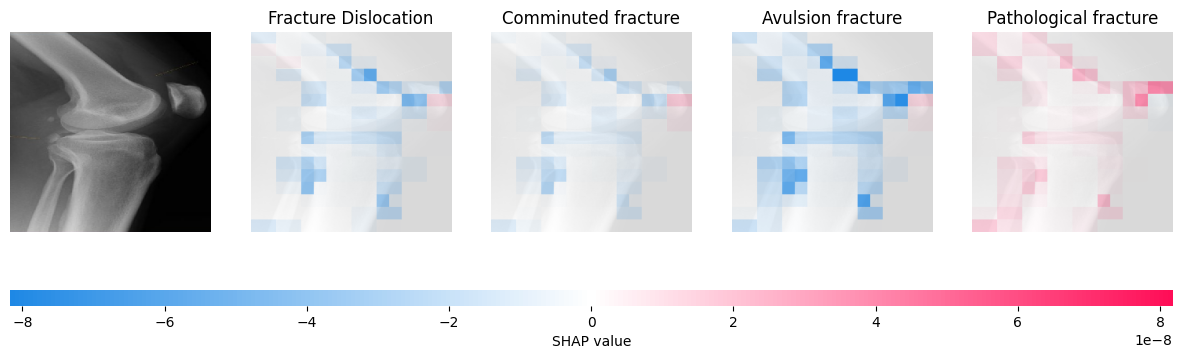

In [32]:
# Masker that will mask out partitions of the input image with smaller blur
masker = shap.maskers.Image("blur(16, 16)", img_array[0].shape)

# Create the explainer
explainer = shap.Explainer(model, masker, output_names=list(class_names_dict.values()))

# Explain the single image to estimate SHAP values
shap_values = explainer(img_array, max_evals=8000, batch_size=50, outputs=shap.Explanation.argsort.flip[:4])  # Increased max_evals

# Show the plot
shap.image_plot(shap_values, pixel_values=img_array)